# CSC 215 - MiniProject 3
## Khoi Hoang

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn.feature_extraction.text as sk_text
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import figure, show
from IPython.display import Markdown, display
%matplotlib inline

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
# Print markdown style
def printmd(string):
    display(Markdown(string))

In [3]:
df = pd.read_csv('network_intrusion_data.csv')
df.columns = [
 'duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'outcome'
]

In [4]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
df.shape

(494020, 42)

In [6]:
# df = df.loc[:, (df != 0).any(axis=0)] #drop columns with all 0
unique_val = df.apply(pd.Series.nunique)
cols_to_drop = unique_val[unique_val==1].index
df = df.drop(cols_to_drop, axis=1)

In [7]:
df.shape

(494020, 40)

In [8]:
np.unique(df['outcome'].values,return_counts=True)

(array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
        'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
        'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
        'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
        'warezclient.', 'warezmaster.'], dtype=object),
 array([  2203,     30,      8,     53,     12,   1247,     21,      9,
             7, 107201,    231,  97277,      3,      4,    264,   1040,
            10,   1589, 280790,      2,    979,   1020,     20]))

In [9]:
# binary encode the outcome, 0 is good/normal and 1 is an attack
df['outcome'] = df['outcome'].apply(lambda x: '0' if x == 'normal.' else '1')

In [10]:
np.unique(df['outcome'].values,return_counts=True)

(array(['0', '1'], dtype=object), array([ 97277, 396743]))

In [11]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [12]:
df.drop_duplicates(keep='first', inplace=True)

In [13]:
df.shape

(145584, 40)

In [14]:
np.unique(df['outcome'].values,return_counts=True)
#df.dtypes

(array(['0', '1'], dtype=object), array([87831, 57753]))

In [15]:
#from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler()

cols_to_normalize = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = scaler.fit_transform(df.select_dtypes(include=['float64','int64']))

numeric_features = pd.DataFrame(numeric_features, columns=cols_to_normalize)

/Users/Megumi/anaconda3/envs/AI/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Megumi/anaconda3/envs/AI/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
numeric_features.shape

(145584, 36)

In [17]:
scaler = preprocessing.LabelEncoder()

cols_to_encode = df.select_dtypes(include=['object']).columns
label_features = df.select_dtypes(include=['object']).apply(scaler.fit_transform)

label_features = pd.DataFrame(label_features, columns=cols_to_encode)

In [18]:
label_features.head()

,protocol_type,service,flag,outcome
0,1,22,9,0
1,1,22,9,0
2,1,22,9,0
3,1,22,9,0
4,1,22,9,0


In [ ]:
label_features.drop(columns=['outcome'], inplace=True)

In [ ]:
label_features.shape

(145584, 3)

In [ ]:
numeric_features.reset_index(drop=True, inplace=True)
label_features.reset_index(drop=True, inplace=True)
input_data = pd.concat([numeric_features, label_features], axis=1)
input_data.shape

(145584, 39)

In [ ]:
output_data = df['outcome']
output_data.shape

(145584,)

# Sklearn models

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=43)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Initiate and train all the models
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

svc = LinearSVC(dual=False)
svc.fit(x_train, y_train)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

gnb = GaussianNB()
gnb.fit(x_train, y_train)

/Users/Megumi/anaconda3/envs/AI/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GaussianNB(priors=None, var_smoothing=1e-09)

-----------------**Logistic Regression Report**---------------

F1 score: 0.9879016033331136
Confusion matrix: 
 [[21785   157]
 [  283 14171]]
Plotting confusion matrix


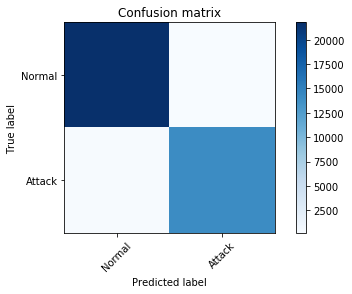

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21942
           1       0.99      0.98      0.98     14454

   micro avg       0.99      0.99      0.99     36396
   macro avg       0.99      0.99      0.99     36396
weighted avg       0.99      0.99      0.99     36396



In [ ]:
y_pred_Logistic = logreg.predict(x_test)
logistic_f1 = metrics.f1_score(y_test, y_pred_Logistic, average= "weighted")
logistic_cm = confusion_matrix(y_test, y_pred_Logistic)
printmd("-----------------**Logistic Regression Report**---------------")
print("F1 score: {}".format(logistic_f1))
print("Confusion matrix: \n", logistic_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(logistic_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_Logistic))

-----------------**SVM Report**---------------

F1 score: 0.9845388227487175
Confusion matrix: 
 [[21767   175]
 [  387 14067]]
Plotting confusion matrix


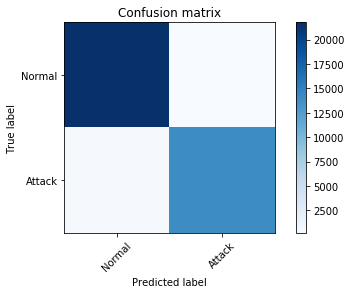

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     21942
           1       0.99      0.97      0.98     14454

   micro avg       0.98      0.98      0.98     36396
   macro avg       0.99      0.98      0.98     36396
weighted avg       0.98      0.98      0.98     36396



In [ ]:
y_pred_svc = svc.predict(x_test)
svc_f1 = metrics.f1_score(y_test, y_pred_svc, average= "weighted")
svc_cm = confusion_matrix(y_test, y_pred_svc)
printmd("-----------------**SVM Report**---------------")
print("F1 score: {}".format(svc_f1))
print("Confusion matrix: \n", svc_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(svc_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_svc))

-----------------**KNN Report**---------------

F1 score: 0.9976089597579206
Confusion matrix: 
 [[21922    20]
 [   67 14387]]
Plotting confusion matrix


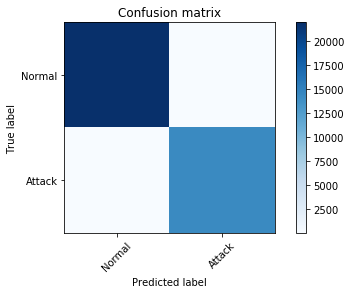

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21942
           1       1.00      1.00      1.00     14454

   micro avg       1.00      1.00      1.00     36396
   macro avg       1.00      1.00      1.00     36396
weighted avg       1.00      1.00      1.00     36396



In [ ]:
y_pred_knn = knn.predict(x_test)
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_cm = confusion_matrix(y_test, y_pred_knn)
printmd("-----------------**KNN Report**---------------")
print("F1 score: {}".format(knn_f1))
print("Confusion matrix: \n", knn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(knn_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_knn))

-----------------**Gaussian Naive Bayes Report**---------------

F1 score: 0.9745197538076749
Confusion matrix: 
 [[21685   257]
 [  668 13786]]
Plotting confusion matrix


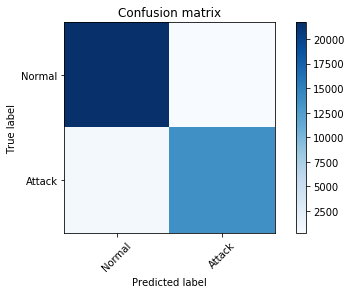

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     21942
           1       0.98      0.95      0.97     14454

   micro avg       0.97      0.97      0.97     36396
   macro avg       0.98      0.97      0.97     36396
weighted avg       0.97      0.97      0.97     36396



In [ ]:
y_pred_gnb = gnb.predict(x_test)
gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average= "weighted")
gnb_cm = confusion_matrix(y_test, y_pred_gnb)
printmd("-----------------**Gaussian Naive Bayes Report**---------------")
print("F1 score: {}".format(gnb_f1))
print("Confusion matrix: \n", gnb_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(gnb_cm, ['Normal', 'Attack'])
plt.show()

print(classification_report(y_test, y_pred_gnb))

# Fully Connected Neural Network model

In [ ]:
scaler = preprocessing.LabelEncoder()
output_tf = scaler.fit_transform(df['outcome'])
output_tf

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
output_tf.shape

(145584,)

In [ ]:
tf_data = input_data.copy()
tf_data['outcome'] = output_tf
tf_data.shape

(145584, 40)

In [ ]:
x, y = to_xy(tf_data, 'outcome')

In [ ]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x, y, test_size=0.25, random_state=43)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow import keras

Using TensorFlow backend.


In [ ]:
checkpointer = ModelCheckpoint(filepath=".\classification.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    
    #Build network
    model = Sequential()

    model.add(Dense(128, input_dim=x_train_tf.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dropout(0.2)) #dropout layer
    model.add(Dense(64, activation='relu')) # Hidden 2
    model.add(Dropout(0.2)) #dropout layer
    model.add(Dense(32, activation='relu')) # Hidden 4
    model.add(Dense(y_train_tf.shape[1], activation='softmax')) # Output
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')

    model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=2,epochs=1000, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    
print('Training finished...Loading the best model')  
print()
model.load_weights('.\classification.hdf5') # load weights from best model

0
Train on 109188 samples, validate on 36396 samples
Epoch 1/1000
